# import

In [1]:
# | code-fold : true

import pandas as pd
import os
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

warnings.filterwarnings(action = "ignore")

# 1. 데이터 로드

`-` 변수정의서

|변수|변수 설명|자료형|변수|변수 설명|자료형|
|:----:|:----:|:----:|:----:|:----:|:----:|
|$X_1$|일반교과교실 개방여부|범주형|$X_{16}$|응급처치교육 시간|숫자형|
|$X_2$|특별교실 개방여부|범주형|$X_{17}$|장애인 주 출입구 접근로 설치 여부|범주형|
|$X_3$|시청각실 개방여부|범주형|$X_{18}$|장애인 전용주차구역 설치 여부|범주형|
|$X_4$|수업교원 1인당 학생 수|숫자형|$X_{19}$|장애인 주 출입구 높이 차이 제거 여부|범주형|
|$X_5$|학생 100명당 동아리 수|숫자형|$X_{20}$|장애인 출입구(문) 설치 유무|범주형|
|$X_6$|교과교실제 운영 여부|숫자형|$X_{21}$|장애인 편의를 위한 복도 설치 유무|범주형|
|$X_7$|자율학교 운영 여부|범주형|$X_{22}$|계단/승강기/경사로/휠체어리프트 유무|범주형|
|$X_8$|수준별수업 운영 여부|범주형|$X_{23}$|장애인용 대변기 설치 여부|범주형|
|$X_9$|교수학습실 수|숫자형|$X_{24}$|장애인용 소변기 설치 여부|범주형|
|$X_{10}$|생활안전교육 시간|숫자형|$X_{25}$|점자블록 설치여부|범주형|
|$X_{11}$|교통안전교육 시간|숫자형|$X_{26}$|유도 및 안내설비 설치 여부|범주형|
|$X_{12}$|폭력예방및신변보호교육 시간|숫자형|$X_{27}$|경보 및 피난설비 설치여부|범주형|
|$X_{13}$|약물중독예방교육 시간|숫자형|$X_{28}$|체육장 개방여부|범주형|
|$X_{14}$|지능정보서비스과의존관련교육 시간|숫자형|$X_{29}$|체육관 개방여부|범주형|
|$X_{15}$|직업안전교육 시간|숫자형|$X_{30}$|강당 개방여부|범주형|


In [2]:
total_data = pd.read_csv("total_data.csv", encoding = "euc-kr")

# 2. target 변수 산출

## (1) 학교시설 개방여부 인코딩

In [3]:
score_data = total_data.loc[:,"x1":"x30"].copy()

`1` target 변수 산출을 위한 학교시설 개방여부에 대한 데이터들은 다음과 같은 규칙을 적용해 숫자로 변경해주자

|$X_i = i\text{번째 학교시설}\text{의 개방여부}$|
|:---:|
|{유 : 1, 무 : 0, 시설없음 : 0}|


In [4]:
score_data.replace(["유","무","시설없음"], [1,0,0], inplace = True) 

## (2) 장애인 편의시설 설치여부 인코딩

`2` 장애인 편의시설 설치여부는 다음과 같은 규칙을 적용한다.

|$X_i = i\text{번째 장애인 편의시설}\text{의 설치여부}$|
|:---:|
|{적정설치 : 2, 단순설치 : 1, 미설치 : 0}|


In [5]:
score_data.replace(["적정설치","단순설치","미설치"], [2,1,0], inplace = True) 

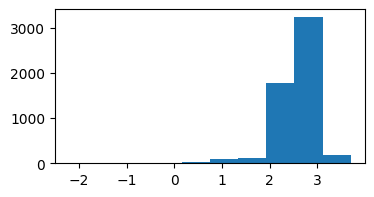

In [6]:
plt.figure(figsize = (4,2))
plt.hist(np.log(score_data.x4+0.01))
plt.show()

## (3) target 변수 산출

`1` 교육시설 시설 점수 :  $s_1 = a_1 + a_2$ 

* $a_1 = (x_1 + x_2 + x_3+x_{28} + x_{29} + x_{30})$

* $a_2 = \alpha \times \log {(x_9)}$

    * $x_9$는 `학생 100명당 교육운영시설 수`로 로그값을 취한 후 더해주었다.

    * $\alpha$ : 학생 100명당 교육운영시설 수 값을 얼마나 반영할 것인지

`2` 교육과정 운영 점수 : $s_2 = (b_1+b_2) - b_3$

* $b_1 = (x_6 + x_7 + x_8)$

* $b_2 = \beta \times \log{(x_5)}$

    * $X_5$는 `학생 100명당 동아리 수`로 로그값을 이용한 후 덧셈을 적용

* $b_3 =  \delta \times \log{(x_4)}$

    * $X_4$는 `수업교원 1인당 학생 수`로 업무의 과중성에 대한 패널티를 부여하기 위해 로그값을 이용한 후 뺄셈을 적용
 
`3` 안전교육시간이수 점수 : $s_3 = \sum_{i=10}^{16} x_i$


`4` 베리어 프리점수 : $s_4 =  \sum_{i=17}^{27} x_i$

### $s_1$. 교육시설점수 

`1` $s_1 = a_1 + a_2$ 

* $a_1 = (x_1 + x_2 + x_3+x_{28} + x_{29} + x_{30})$

* $a_2 = \alpha \times \log {(x_9)}$

    * $x_9$는 `학생 100명당 교육운영시설 수`로 로그값을 취한 후 더해주었다.

    * $\alpha$ : 학생 100명당 교육운영시설 수 값을 얼마나 반영할 것인지

In [7]:
## parameter 셋팅

alpha = 0.5

a1 = score_data.loc[:,["x1","x2","x3","x28","x29","x30"]].sum(axis = 1)
a2 = alpha*np.log(score_data["x9"])

s1 = a1 + a2

<Axes: >

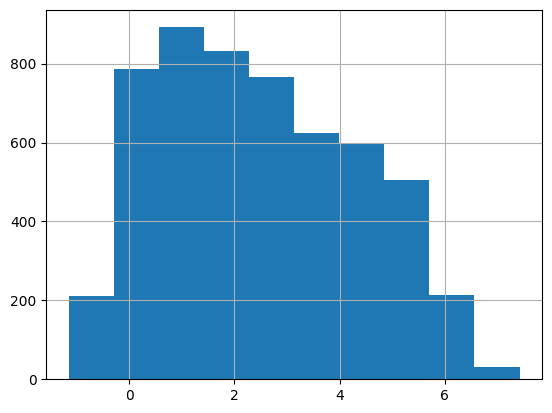

In [8]:
s1.hist()

### $s_2$  : 교육과정운영점수

`2` 교육과정 운영 점수 : $s_2 = (b_1+b_2) - b_3$

* $b_1 = (x_6 + x_7 + x_8)$

* $b_2 = \beta \times \log{(x_5)}$

    * $X_5$는 `학생 100명당 동아리 수`로 로그값을 이용한 후 덧셈을 적용
 
    *  $\beta$ :  학생 100명당 동아리 수 값을 얼마나 반영할 것인지

* $b_3 =  \delta \times \log{(x_4)}$

    * $X_4$는 `수업교원 1인당 학생 수`로 업무의 과중성에 대한 패널티를 부여하기 위해 로그값을 이용한 후 뺄셈을 적용

    * $\delta$ : 업무 과중 패널티를 얼마나 부여할 것인지
 

In [9]:
beta = 0.7
delta = 0.05

b1 = score_data.loc[:, "x6" : "x7"].sum(axis=1)
b2 = beta*np.log(score_data["x5"])
b3 = delta*np.log(score_data["x4"])

s2 = b1 + b2 + b3

<Axes: >

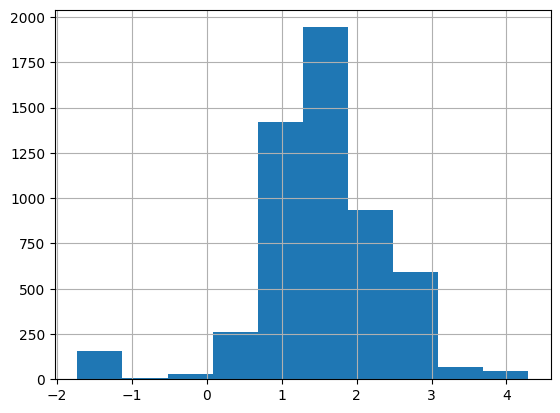

In [10]:
s2.hist()

### $s_3$ : 안전교육시간 이수 점수

$s_3 = \sum_{i=10}^{16} x_i$

In [11]:
s3 = score_data.loc[:,"x10":"x16"].sum(axis=1) + 0.1 ## -inf방지를 위해

<Axes: >

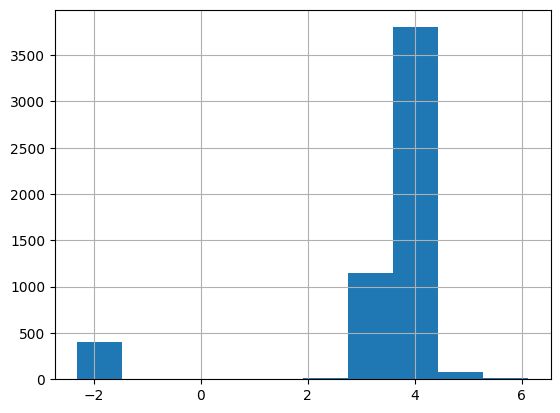

In [12]:
np.log(s3).hist()

### $s_4$ : 베리어프리점수

$s_4 = \sum_{i=17}^{27} x_i$

In [13]:
s4 = score_data.loc[:,"x17":"x27"].sum(axis=1) + 0.1 ## -inf방지를 위해

<Axes: >

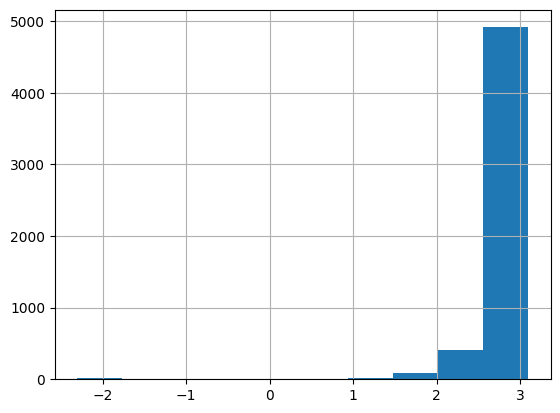

In [14]:
np.log(s4).hist()

### target 변수 산출

In [15]:
y = (s1+s2+np.log(s3)+np.log(s4))

In [16]:
total_data["y"] = y
total_data["s1"] = y
total_data["s2"] = y
total_data["s3"] = y
total_data["s4"] = y

total_data.to_csv("final_data.csv",encoding = "euc-kr", index = False)

<Axes: >

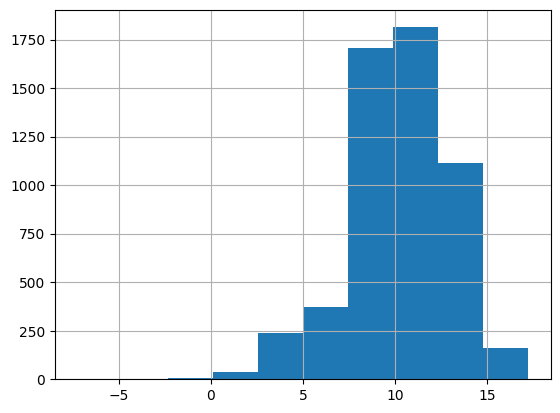

In [17]:
y.hist()

# 3. 간단한 모델링

## (1) 데이터 로드

In [18]:
data = pd.read_csv("final_data.csv", encoding = "euc-kr")
data = data.loc[:,"x1" : "y"]

In [19]:
data["x6"] = data["x6"].astype(str)
data["x7"] = data["x6"].astype(str)
data["x8"] = data["x6"].astype(str)

## (2) 더미변수 변환

In [20]:
d_col = data.select_dtypes("O").columns.values
d_col

array(['x1', 'x2', 'x3', 'x6', 'x7', 'x8', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30'], dtype=object)

In [21]:
data1 = pd.get_dummies(data = data, columns = d_col, drop_first = True)

## (3) 훈련, 평가 데이터 분리

In [22]:
target = "y"

X = data1.drop(target, axis = 1)
y = data1[target]

In [23]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 8:2으로 분리
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## (4) 모델링 수행

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth = 5, random_state = 1) ## default tree = 100

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

## (5) 모델 평가

In [25]:
from sklearn.metrics import *

In [26]:
mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(0.7543269300063966, 0.9146970485132919)

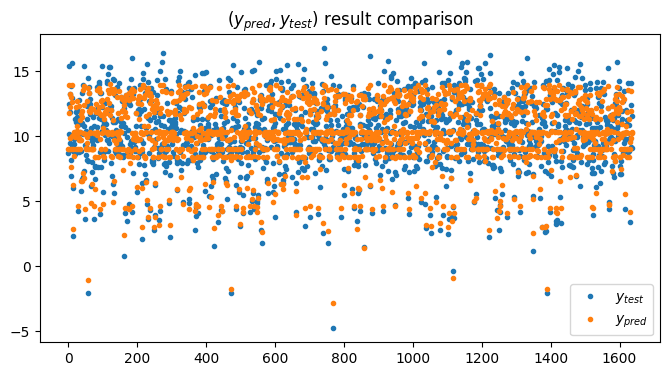

In [27]:
plt.figure(figsize = (8,4))
plt.plot(y_test.values,".", label = r"$y_{test}$")
plt.plot(y_pred,".",label = r"$y_{pred}$")
plt.title(r"$(y_{pred},y_{test})$ result comparison")
plt.legend()
plt.show()

# 4. target 변수 산출 정리

`1` 교육시설점수 : $s_1 = a_1 + a_2$ 

* $a_1 = (x_1 + x_2 + x_3+x_{28} + x_{29} + x_{30})$

* $a_2 = \alpha \times \log {(x_9)}$

    * $x_9$는 `학생 100명당 교육운영시설 수`로 로그값을 취한 후 더해주었다.

    * $\alpha$ : 학생 100명당 교육운영시설 수 값을 얼마나 반영할 것인지, 본 연구에서는 0.5를 적용


`2` 교육과정 운영 점수 : $s_2 = (b_1+b_2) - b_3$

* $b_1 = (x_6 + x_7 + x_8)$

* $b_2 = \beta \times \log{(x_5)}$

    * $X_5$는 `학생 100명당 동아리 수`로 로그값을 이용한 후 덧셈을 적용
 
    *  $\beta$ :  학생 100명당 동아리 수 값을 얼마나 반영할 것인지, 본 연구에서는 0.7을 적용 

* $b_3 =  \delta \times \log{(x_4)}$

    * $X_4$는 `수업교원 1인당 학생 수`로 업무의 과중성에 대한 패널티를 부여하기 위해 로그값을 이용한 후 뺄셈을 적용

    * $\delta$ : 업무 과중 패널티를 얼마나 부여할 것인지, 본 연구에서는 0.05를 적용
 
 
`3` 안전교육시간 이수 점수 : $s_3 = \sum_{i=10}^{16} x_i$

`4` 베리어프리 점수 : $s_4 = \sum_{i=17}^{27} x_i$

`5` 최종학교평가 score : $y = s_1 + s_2 + \log(s_3) + + \log(s_4)$

